# Data Import and Cleaning 

#### Datasets from here: 
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-1.html
- https://www.census.gov/programs-surveys/sipp/data/datasets/2008-panel/wave-2.html
#### Column definition from here: 
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/l08puw1.sas
- https://www2.census.gov/programs-surveys/sipp/data/datasets/2008/p08putm1.sas

In [2]:
import numpy as np
import pandas as pd

## Import SIPP data

In [1]:
# sas input statement needs to be cleaned by hand: remove all whitespaces and $-signs e.g. replace ' -' with '-'
# columns that should be kept, need to be defined by hand as well
def import_sipp_data(sas_input_statement, dat_file, columns_keep):
    input_dict = np.loadtxt(sas_input_statement, dtype = str)
    column_lst = input_dict[:, 0].tolist()
    
    colspecs = []
    for string in input_dict[:, 1]:
        tpl_temp = tuple(map(int, string.split('-')))
        tpl_temp = (tpl_temp[0]-1, tpl_temp[1]) # second number should also be corrected?
        colspecs.append(tpl_temp)
    df_raw = pd.read_fwf(dat_file, names=column_lst, colspecs=colspecs)

    df = df_raw[columns_keep]
    del df_raw
    return df

In [3]:
# columns core dataset
clmn_join = ['SSUID', 'SPANEL', 'SWAVE', 'TFIPSST', 'EOUTCOME', 'SHHADID', 'RFID', 'RFID2', 'EENTAID','EPPPNUM', 'EPOPSTAT', 'EPPINTVW', 'ESEX', 
            'ERACE', 'EORIGIN', 'WPFINWGT', 'ERRP', 'EMS', 'EPNMOM', 'EPNDAD', 'EPNGUARD', 'EPNSPOUS', 'RDESGPNT', 'TAGE', 'EEDUCATE']

clmn_general = ['SREFMON', 'EHREFPER', 'RHCALMN', 'RHCALYR', 'TMOVRFLG', 'EHHNUMPP', 'EFSPOUSE', 'RFNKIDS', 'EBORNUS', 'ECITIZEN', 'RENROLL', 'EFKIND']

# make hist for all income categories and combine the small ones into a new 'other' or substract all interesting income streams from total and take the residual.
clmn_income = ['TFEARN', 'TFTOTINC', 'TPEARN', 'TPTOTINC', 'THTRNINC', 'THOTHINC', 'ETENURE', 'THPNDIST', 'THSOCSEC', 'THVETS', 'THLUMPSM', 'THAFDC', 
                'EAST1C', 'THPRPINC', 'TINTINC', 'TDIVINC', 'EAST3B', 'EAST3C', 'EAST3D', 'EAST3E', 'EAST4A' ]
                
clmn_labor = ['EPAYHR1', 'EPAYHR2', 'TPYRATE1', 'TPYRATE2', 'EJBHRS1', 'EJBHRS2', 'EUNION1', 'EUNION2', 'TMLMSUM', 'EDISABL', 'EDISPREV', 
                'EAWOP', 'EABRE', 'ERSNOWRK', 'EPTRESN', 'EBUSCNTR', 'EJOBCNTR', 'RMWKSAB', 'EPDJBTHN', 'ELKWRK', 'ELAYOFF', 'EHRSALL', 'EMOONLIT', 'RMHRSWK', 'EPTWRK', 
                'RMESR', 'RMWKWJB', 'RWKSPERM', 'EBNO1', 'EBNO2']

columns_core = clmn_join + clmn_general + clmn_income + clmn_labor
print('length core columns: ', len(columns_core))

# columns topical dataset
clmn_join

clmn_rebate = ['EREBATE', 'ERBAMTH', 'ERBATAMT', 'ERBATTYP', 'EREBATOC']

columns_topical = clmn_join + clmn_rebate
print('length topical columns: ', len(columns_topical))

# potential columns to add: TMTHRNT (total rent), RHCHANGE(change in HH composition), RFCHANGE(change in family composition)

length core columns:  87
length topical columns:  30


In [5]:
w2_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw2.dat', columns_core)
print('w2 core imported')
w2_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w2.csv') 
print('w2 core exported to csv')

w1_core = import_sipp_data('input_core.txt', '/Users/maxweber/Desktop/DataMasterThesis/l08puw1.dat', columns_core)
print('w1 core imported')
w1_core.to_csv('/Users/maxweber/Desktop/DataMasterThesis/core_w1.csv') 
print('w1 core exported to csv')

w1_topical = import_sipp_data('input_topical_w1.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm1.dat', columns_topical)
print('w1 topical imported')
w1_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w1.csv') 
print('w1 topical exported to csv')

w2_topical = import_sipp_data('input_topical_w2.txt', '/Users/maxweber/Desktop/DataMasterThesis/p08putm2.dat', columns_topical)
print('w2 topical imported')
w2_topical.to_csv('/Users/maxweber/Desktop/DataMasterThesis/topical_w2.csv') 
print('w2 topical exported to csv')

[(0, 5), (5, 17), (17, 21), (21, 23), (23, 24), (24, 25), (25, 27), (27, 31), (31, 34), (34, 37), (37, 38), (38, 41), (41, 43), (43, 45), (45, 48), (48, 50), (50, 52), (52, 54), (54, 58), (58, 61), (61, 62), (62, 72), (72, 73), (73, 74), (74, 76), (76, 77), (77, 78), (78, 80), (80, 81), (81, 83), (83, 84), (84, 90), (90, 91), (91, 93), (93, 94), (94, 96), (96, 97), (97, 99), (99, 100), (100, 102), (102, 104), (104, 106), (106, 107), (107, 112), (112, 113), (113, 115), (115, 116), (116, 118), (118, 120), (120, 121), (121, 123), (123, 124), (124, 126), (126, 127), (127, 129), (129, 131), (131, 132), (132, 134), (134, 135), (135, 136), (136, 143), (143, 151), (151, 158), (158, 165), (165, 173), (173, 175), (175, 177), (177, 179), (179, 184), (184, 191), (191, 199), (199, 205), (205, 211), (211, 217), (217, 223), (223, 229), (229, 235), (235, 241), (241, 244), (244, 247), (247, 249), (249, 253), (253, 257), (257, 259), (259, 260), (260, 262), (262, 264), (264, 266), (266, 268), (268, 270),

In [6]:
print(w1_core.shape)
print(w1_topical.shape)
w1_full = w1_core.merge(w1_topical, how = 'left', on = clmn_join)
w1_full.shape

print(w2_core.shape)
print(w2_topical.shape)
w2_full = w2_core.merge(w2_topical, how = 'left', on = clmn_join)
w2_full.shape

df = pd.concat([w1_full, w2_full])
df.drop('Unnamed: 0', inplace = True, axis=1)

df.to_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv') 
print(df.shape)
del [w1_core, w2_core, w1_topical, w2_topical]

df.head()

(421911, 87)
(105663, 30)


(421911, 92)

In [225]:
df = pd.read_csv('/Users/maxweber/Desktop/DataMasterThesis/full_sipp.csv')
df.drop('Unnamed: 0', inplace = True, axis=1)
df.shape

(814613, 92)

## Data Cleaning and Feature Engineering

In [238]:
df['pp'] = df.groupby(['SSUID','EPPPNUM']).ngroup()
df.set_index('pp', drop= True, inplace = True)
print(len(df.index.unique())) #95577 unique
pp_count = df.groupby(['pp'], as_index=False).size() # columns: pp and size
df = df.merge(pp_count, how = 'outer', on = 'pp')
df = df[df['size']== 8]
df.drop('size', axis=1, inplace = True)

df.shape # 764.616 from 814.613 before

73471


(587768, 100)

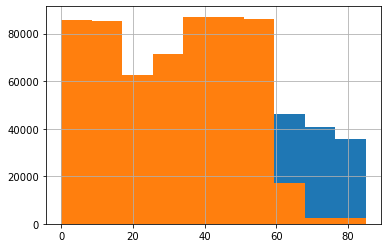

In [227]:
#Powell: I require the head of the household to be between 25 and 60 years old
# EHREFPER = EPPPNUM and TAGE => 25 and TAGE <= 60 (this can be optimized by looking at first or last month of observed timeframe)
df['TAGE'].describe()
min_tage = df.groupby(df.index)['TAGE'].min().rename('min_tage')
max_tage = df.groupby(df.index)['TAGE'].max().rename('max_tage')

df = df.merge(min_tage, how = 'left', left_index = True, right_index = True)
df = df.merge(max_tage, how = 'left', left_index = True, right_index = True)

ssuids_age = df[(df['EHREFPER'] == df['EPPPNUM']) & (df['min_tage']>= 25)  & (df['max_tage'] <= 60)]['SSUID'].unique()

df[~df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df[df['SSUID'].isin(ssuids_age)]['TAGE'].hist()
df = df[df['SSUID'].isin(ssuids_age)]
# seems reasonable. next step is to aggregate to houshold level to further reduce #of HH

In [239]:
len(df[df['SSUID'].isin(ssuids_age)]['SSUID'].unique())

26238

In [230]:
# create the total month variable with year and month
def get_total_month(year,month):
    if year == 2009:
        return month+12
    else:
        return month
        
df['month_total'] = df.apply(lambda x: get_total_month(x['RHCALYR'],x['RHCALMN']),axis=1)

np.nan can only be conditioned on by np.isna() and pd.isnull() <br>
np.nan == np.nan -> False

In [232]:
# correct the rebated if EREBATE = 2 -> EREBATE = 0; if EREBATE = -1 -> EREBATE = np.NaN
df['erebate'] = df['EREBATE']
print(df[~df['erebate'].isnull()]['erebate'].unique()) # 2 -> 0 & -1 -> np.NaN
df['erebate'] = df['EREBATE'].replace({2 : 0, -1 : np.NaN})

df['erbamth'] = df['ERBAMTH'].replace(-1, np.NaN)
df['erebatoc'] = df['EREBATOC'].replace(-1, np.NaN)
df['erbattyp'] = df['ERBATTYP'].replace(-1, np.NaN)

[ 2. -1.  1.]


array([[<AxesSubplot:title={'center':'erebate'}>,
        <AxesSubplot:title={'center':'erbamth'}>],
       [<AxesSubplot:title={'center':'erbattyp'}>,
        <AxesSubplot:title={'center':'erebatoc'}>]], dtype=object)

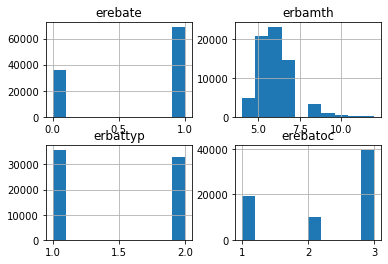

In [235]:
df[['erebate','erbamth', 'erbattyp', 'erebatoc']].hist()

In [ ]:
# generate dummy for change in maritial status
# from EFKIND: 1 if married, 2 and 3 if HH headed by unmarried man/woman -> spouse dummy : 1 if married

df['spouse'] = df['EFKIND']
spouse_sum = df.groupby(['pp'])['spouse'].sum()
df = df.merge(df.groupby(['pp'])['spouse'].sum(), on = 'pp', how = 'left' )
df['spouse'] = df['spouse_x']
df['spouse_sum'] = df['spouse_y']
df.drop('spouse_x', axis = 1, inplace = True)
df.drop('spouse_y', axis = 1, inplace = True)

#houshold[['spouse', 'spouse_sum']].describe()
#houshold['spouse_sum'].unique()

def get_change_spouse(spouse_sum):
    if spouse_sum == 0 or spouse_sum == 8 :
        return 0
    else:
        return 1
        
df['change_spouse'] = df.apply(lambda x: get_change_spouse(x['spouse_sum']),axis=1)

df[['change_spouse', 'spouse_sum']].describe()
df.drop('spouse_sum', inplace = True)

## Open Questions

- SSUID leading zeros are gone since not string type?
- 75% instead of 81% rebated -> changes after grouping for HHs and subsetting?
- should I include famsize > 6 => famsize == 6?
- is there a difference between houshold and familysize? combine?
- is it viable to join earn_male/earn_female/spouse over SSUID and EPPPNUM if not able to recreate?
- the pp_count creation with count() instead of size()??


## ToDo Data Cleaning
- topical modul joined only once per wave and needs to be in every row (change join or fill the other rows)
- redefine the dummy variables as 1, 0, np.NaN !! the function does not work yet!!
- generate dummy for change in maritial status
- aggregate to HH level
> analysis on HH level: tot_income, higher income, lower income, difference in income, sex of top earner
- compare to houshold dataframe and individual dataframe
- subset on interview status? if missing data -> drop?


## ToDo Data Description
- make list if continous and categorical variables to make dummy creation easier
- categrocial variables to string
- make star scheme to map the codes to their description.
- explorea dn describe each variable used graphically if possible

## ToDo Analysis
- Baseline analysis
- Select grouping variables 
- Select ranges for each group

# Variable names of modified data in lower caps to show that not the original data is used.